# Classical IR — TF-IDF & BM25 (Whoosh) with Evaluation Metrics and Query Sets

This notebook demonstrates:

- A TF-IDF vector-space baseline (scikit-learn)
- BM25 retrieval using **Whoosh** (pure-Python)
- Two query categories: *Terminological* and *Conceptual*
- Evaluation metrics: Precision@k, MAP (mean average precision), nDCG@k
- Plots comparing models overall and by query type

Replace `SAMPLE_DOCS`, queries, and `QRELS` with your real corpus and labels.


## ✅ Query Design
We prepare two categories of queries:

- **Terminological Queries**: precise, keyword-driven. Expect classical models (BM25/TF-IDF) to perform well.
- **Conceptual Queries**: higher-level, semantic. Expect neural models to have advantage (to be added later).

Below are example queries tailored to the small sample corpus; you should craft ~5–10 of each type for your real experiments.

In [1]:
# --- Sample preprocessed corpus (replace with your own) ---
SAMPLE_DOCS = [
    "security council discuss peacekeeper mandate west africa focus training logistics",
    "resolution stipulation address political process ceasefire syria include humanitarian corridor",
    "sanction arm trade tighten reduce illicit flow destabilize region",
    "nuclear nonproliferation discussion emphasize verification international cooperation framework",
    "counterterrorism committee mandate state reporting requirement national measure",
    "blue helmet deployment rule update include better equipment medical support",
    "human right reporting requirement include regular briefing independent monitoring mission",
    "ceasefire monitoring mission extend presence conflict zone ensure compliance",
    "women peace security agenda highlight participation protection peace process",
    "humanitarian corridor syria coordinate allow aid delivery besieged area",
]

# Terminological (keyword-focused) queries
TERMINOLOGICAL_QUERIES = [
    "peacekeeper mandate west africa",
    "resolution stipulation syria",
    "sanctions arms trade",
    "nuclear nonproliferation verification",
    "counterterrorism committee reporting",
]

# Conceptual (semantic / broader intent) queries
CONCEPTUAL_QUERIES = [
    "documents about humanitarian aid access in syria",
    "policies for deploying peacekeepers and their equipment",
    "monitoring missions that ensure ceasefire compliance",
    "reports on human rights monitoring and independent briefings",
    "agenda on women's participation in peace processes",
]

# Merge for evaluation (we keep order and remember indices)
SAMPLE_QUERIES = TERMINOLOGICAL_QUERIES + CONCEPTUAL_QUERIES

# Example QRELS (0-based doc indices) - replace with your own relevance labels
QRELS = {
    0: {0},
    1: {1},
    2: {2},
    3: {3},
    4: {4},
    5: {1,9},
    6: {0,5},
    7: {1,7},
    8: {6},
    9: {8},
}

TOP_K = 5
print(f'Prepared {len(TERMINOLOGICAL_QUERIES)} terminological and {len(CONCEPTUAL_QUERIES)} conceptual queries. Total queries: {len(SAMPLE_QUERIES)}')


Prepared 5 terminological and 5 conceptual queries. Total queries: 10


## Install & imports

In [4]:
# Install
!pip install whoosh scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 7.6 MB/s eta 0:00:00


In [5]:
from typing import List, Dict, Set
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Whoosh imports
from whoosh import index, fields, qparser, scoring, analysis
from whoosh.index import create_in, open_dir
import os, shutil, tempfile


## Build TF-IDF baseline (scikit-learn)

In [6]:
# TF-IDF vectorizer: we assume input is preprocessed so we use whitespace tokenizer
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=str.split, preprocessor=None, token_pattern=None)
X = vectorizer.fit_transform(SAMPLE_DOCS)
print('Built TF-IDF matrix shape:', X.shape)

Built TF-IDF matrix shape: (10, 78)


## Create Whoosh index (BM25) and add documents

In [7]:
# Create Whoosh index in a temporary directory
schema = fields.Schema(doc_id=fields.ID(stored=True, unique=True),
                       content=fields.TEXT(stored=True, analyzer=analysis.SimpleAnalyzer()))

index_dir = os.path.join(tempfile.gettempdir(), "whoosh_mini_ir_index_only")
if os.path.exists(index_dir):
    shutil.rmtree(index_dir)
os.makedirs(index_dir, exist_ok=True)
ix = create_in(index_dir, schema)
writer = ix.writer()

for i, text in enumerate(SAMPLE_DOCS):
    writer.add_document(doc_id=str(i), content=text)
writer.commit()
print('Whoosh index created at', index_dir)

Whoosh index created at /tmp/whoosh_mini_ir_index_only


## Search Whoosh using BM25F scoring

Whoosh implements BM25-like scoring via `scoring.BM25F`. We set parameters `K1` and `B` below.

In [8]:
# Search function using Whoosh BM25F
def search_whoosh(query: str, top_k: int = 10, k1: float = 1.5, b: float = 0.75):
    with ix.searcher(weighting=scoring.BM25F(B=b, K1=k1)) as searcher:
        qp = qparser.QueryParser("content", schema=ix.schema)
        # Use 'AND' operator for strict matching and Change to 'OR' to be looser.
        qp.remove_plugin_class(qparser.WildcardPlugin)  # To keep parser as simple as possible
        q = qp.parse(query)
        hits = searcher.search(q, limit=top_k)
        results = []
        for h in hits:
            doc_idx = int(h['doc_id'])
            score = float(h.score)
            snippet = h['content'][:300]
            results.append((doc_idx, score, snippet))
        return results

# Quick sample example
print('Whoosh example search:', search_whoosh('peacekeeper mandate west africa', top_k=5)[:3])

Whoosh example search: [(0, 9.654501692780311, 'security council discuss peacekeeper mandate west africa focus training logistics')]


## Unified ranking functions (TF-IDF & Whoosh BM25)

In [9]:
def rank_tfidf(query: str, top_k: int = 10):
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, X)[0]
    ranked_idx = sims.argsort()[::-1][:top_k]
    return [(int(i), float(s)) for i, s in zip(ranked_idx, sims[ranked_idx])]

def rank_bm25_whoosh(query: str, top_k: int = 10):
    res = search_whoosh(query, top_k=top_k)
    return [(int(r[0]), float(r[1])) for r in res]

## Evaluation metrics (Precision@k, AP/MAP, nDCG@k)

In [10]:
def precision_at_k(retrieved: List[int], relevant: Set[int], k: int) -> float:
    if k == 0: return 0.0
    retrieved_k = retrieved[:k]
    rel_count = sum(1 for doc in retrieved_k if doc in relevant)
    return rel_count / k

def average_precision(retrieved: List[int], relevant: Set[int]) -> float:
    if not relevant:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, doc in enumerate(retrieved, start=1):
        if doc in relevant:
            num_hits += 1.0
            score += num_hits / i
    return score / len(relevant)

def dcg_at_k(retrieved: List[int], relevant: Set[int], k: int) -> float:
    dcg = 0.0
    for i, doc in enumerate(retrieved[:k], start=1):
        rel = 1.0 if doc in relevant else 0.0
        denom = math.log2(i+1)
        dcg += (2**rel - 1) / denom
    return dcg

def idcg_at_k(relevant: Set[int], k: int) -> float:
    ideal_rels = sorted([1]*min(len(relevant), k) + [0]*max(0, k - len(relevant)), reverse=True)
    idcg = 0.0
    for i, rel in enumerate(ideal_rels, start=1):
        idcg += (2**rel - 1) / math.log2(i+1)
    return idcg

def ndcg_at_k(retrieved: List[int], relevant: Set[int], k: int) -> float:
    idcg = idcg_at_k(relevant, k)
    if idcg == 0.0:
        return 0.0
    dcg = dcg_at_k(retrieved, relevant, k)
    return dcg / idcg

## Evaluation runner and results table

In [11]:
def evaluate_rank_fn(rank_fn, queries, qrels, top_k=5):
    rows = []
    aps = []; ndcgs = []; pks = []
    for qi, q in enumerate(queries):
        ranked = rank_fn(q, top_k=top_k)
        retrieved = [r[0] for r in ranked]
        scores = [r[1] for r in ranked]
        relevant = qrels.get(qi, set())
        ap = average_precision(retrieved, relevant)
        ndcg = ndcg_at_k(retrieved, relevant, top_k)
        pk = precision_at_k(retrieved, relevant, top_k)
        rows.append({'query_id': qi, 'query': q, 'retrieved': retrieved, 'scores': scores, 'relevant': sorted(list(relevant)), 'AP': ap, 'nDCG': ndcg, 'P@k': pk})
        aps.append(ap); ndcgs.append(ndcg); pks.append(pk)
    overall = {'MAP': float(np.mean(aps)), f'nDCG@{top_k}': float(np.mean(ndcgs)), f'P@{top_k}': float(np.mean(pks))}
    return pd.DataFrame(rows), overall

# Run evaluations
tfidf_df, tfidf_overall = evaluate_rank_fn(rank_tfidf, SAMPLE_QUERIES, QRELS, top_k=TOP_K)
whoosh_df, whoosh_overall = evaluate_rank_fn(rank_bm25_whoosh, SAMPLE_QUERIES, QRELS, top_k=TOP_K)

print('TF-IDF overall:', tfidf_overall)
print('Whoosh BM25 overall:', whoosh_overall)

TF-IDF overall: {'MAP': 0.95, 'nDCG@5': 0.9613147192765459, 'P@5': 0.24000000000000005}
Whoosh BM25 overall: {'MAP': 0.4, 'nDCG@5': 0.4, 'P@5': 0.08}


## Aggregate by query type and plots

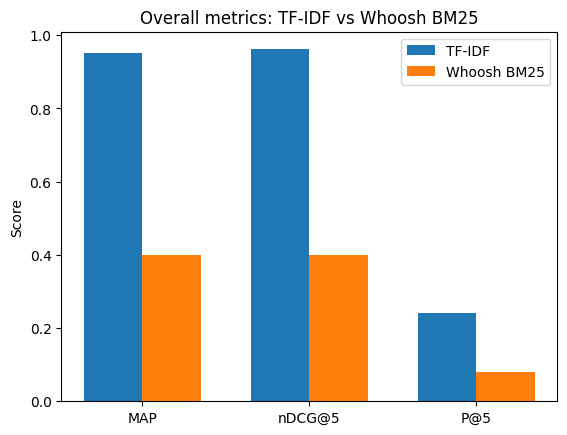

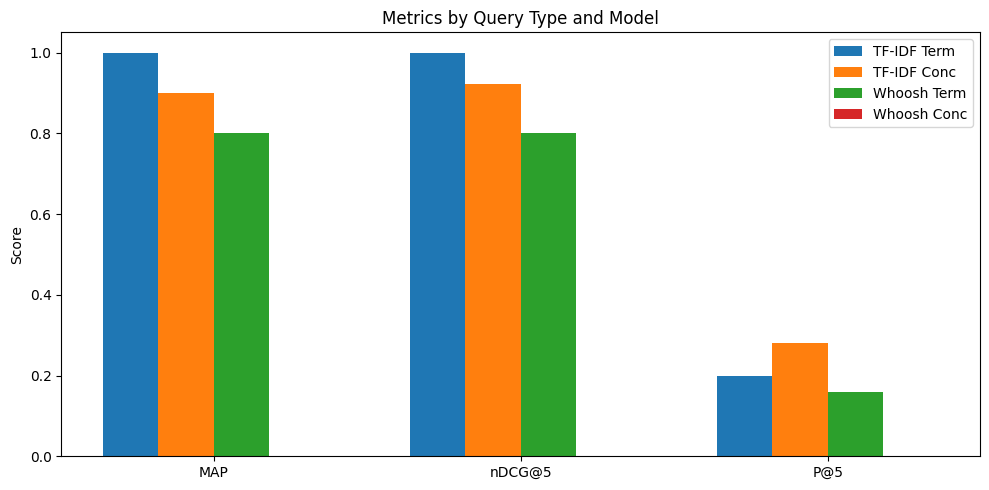

In [15]:
def aggregate_by_type(metrics_df, terminological_queries):
    term = metrics_df.iloc[:len(TERMINOLOGICAL_QUERIES)]
    conc = metrics_df.iloc[len(TERMINOLOGICAL_QUERIES):]
    term_vals = {'MAP': float(term['AP'].mean()), f'nDCG@{TOP_K}': float(term['nDCG'].mean()), f'P@{TOP_K}': float(term['P@k'].mean())}
    conc_vals = {'MAP': float(conc['AP'].mean()), f'nDCG@{TOP_K}': float(conc['nDCG'].mean()), f'P@{TOP_K}': float(conc['P@k'].mean())}
    return term_vals, conc_vals

tfidf_term, tfidf_conc = aggregate_by_type(tfidf_df, SAMPLE_QUERIES)
whoosh_term, whoosh_conc = aggregate_by_type(whoosh_df, SAMPLE_QUERIES)

# Plot overall comparison
metrics_names = ['MAP', f'nDCG@{TOP_K}', f'P@{TOP_K}']
tfidf_vals = [tfidf_overall['MAP'], tfidf_overall[f'nDCG@{TOP_K}'], tfidf_overall[f'P@{TOP_K}']]
whoosh_vals = [whoosh_overall['MAP'], whoosh_overall[f'nDCG@{TOP_K}'], whoosh_overall[f'P@{TOP_K}']]

x = np.arange(len(metrics_names)); width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, tfidf_vals, width)
ax.bar(x + width/2, whoosh_vals, width)
ax.set_xticks(x); ax.set_xticklabels(metrics_names)
ax.set_ylabel('Score'); ax.set_title('Overall metrics: TF-IDF vs Whoosh BM25')
ax.legend(['TF-IDF','Whoosh BM25'])
plt.show()

# Plot by query type
labels = metrics_names
term_vals_tf = [tfidf_term['MAP'], tfidf_term[f'nDCG@{TOP_K}'], tfidf_term[f'P@{TOP_K}']]
conc_vals_tf = [tfidf_conc['MAP'], tfidf_conc[f'nDCG@{TOP_K}'], tfidf_conc[f'P@{TOP_K}']]
term_vals_who = [whoosh_term['MAP'], whoosh_term[f'nDCG@{TOP_K}'], whoosh_term[f'P@{TOP_K}']]
conc_vals_who = [whoosh_conc['MAP'], whoosh_conc[f'nDCG@{TOP_K}'], whoosh_conc[f'P@{TOP_K}']]
x = np.arange(len(labels)); width = 0.18
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - 1.5*width, term_vals_tf, width)
ax.bar(x - 0.5*width, conc_vals_tf, width)
ax.bar(x + 0.5*width, term_vals_who, width)
ax.bar(x + 1.5*width, conc_vals_who, width)
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel('Score'); ax.set_title('Metrics by Query Type and Model')
ax.legend(['TF-IDF Term','TF-IDF Conc','Whoosh Term','Whoosh Conc'])
plt.tight_layout(); plt.show()